In [1]:
import pickle
import datetime

In [2]:
import sys
sys.path.insert(0,'/homelocal/mrilee/git/pystareplotlib')

import os
os.environ['PROJ_LIB'] = '/homelocal/mrilee/opt/anaconda3/envs/stare-1/share/proj'

import pystare
import starepandas
import geopandas

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs

import pystareplotlib
import pystareplotlib.pystareplotlib as psplot

import numpy


plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

plot_options['projection']._threshold = 0.01;

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def mnmx(x):
    return min(x),max(x)
def span(x):
    return max(x)-min(x)

In [5]:
start = datetime.datetime.now()

In [6]:
data_dir = '/tablespace/xcal/'
with open(f'{data_dir}/pickles/featuredb.pickle', 'rb') as f:
    features = pickle.load( f)

# Load US States

In [7]:
states = geopandas.read_file('ignored/tl_2019_us_state.zip')

In [8]:
states = starepandas.STAREDataFrame(states)
sids = states.make_sids(n_workers=50, resolution=10)
states.set_sids(sids, inplace=True)
trixels = states.make_trixels(n_workers=50, wrap_lon=False)
states.set_trixels(trixels, inplace=True)
states.split_antimeridian(inplace=True)

In [9]:
alabama = states[states['NAME']=='Alabama']
alabama_sids = alabama.sids.iloc[0]

<AxesSubplot:>

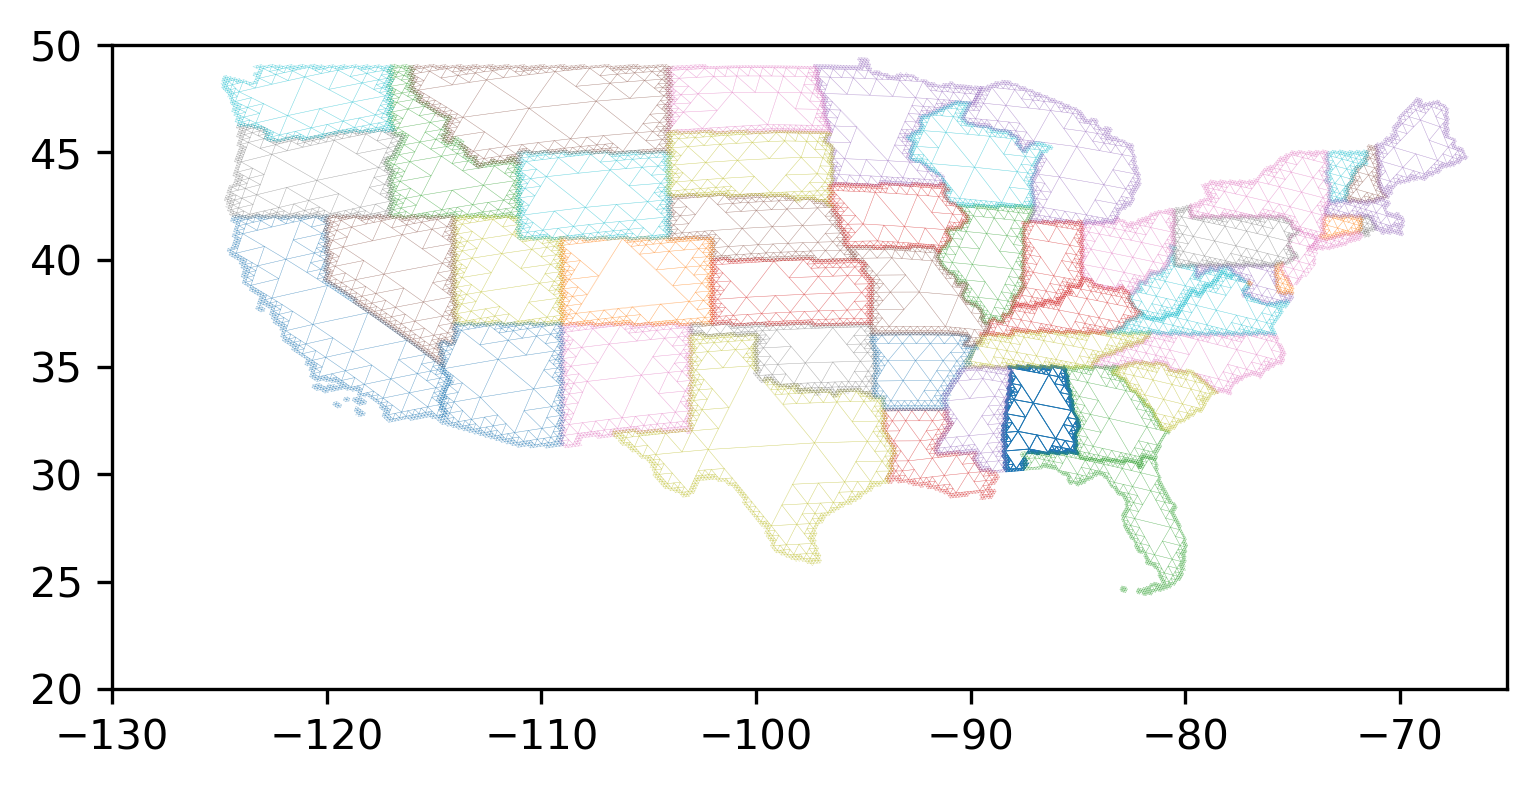

In [10]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot()

ax.set_xlim(-130, -65)
ax.set_ylim(20, 50)

alabama.plot(ax=ax, linewidth=0.2)
states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

# Pull out events intersecting Alabama

In [11]:
intersects = features.stare_intersects(alabama_sids, n_workers=60)
features[intersects].label.unique()

array([17, 65, 74, 91, 94], dtype=int32)

# Inspecting the first event (17)

In [12]:
event_17 = features[features.label==17]

<AxesSubplot:>

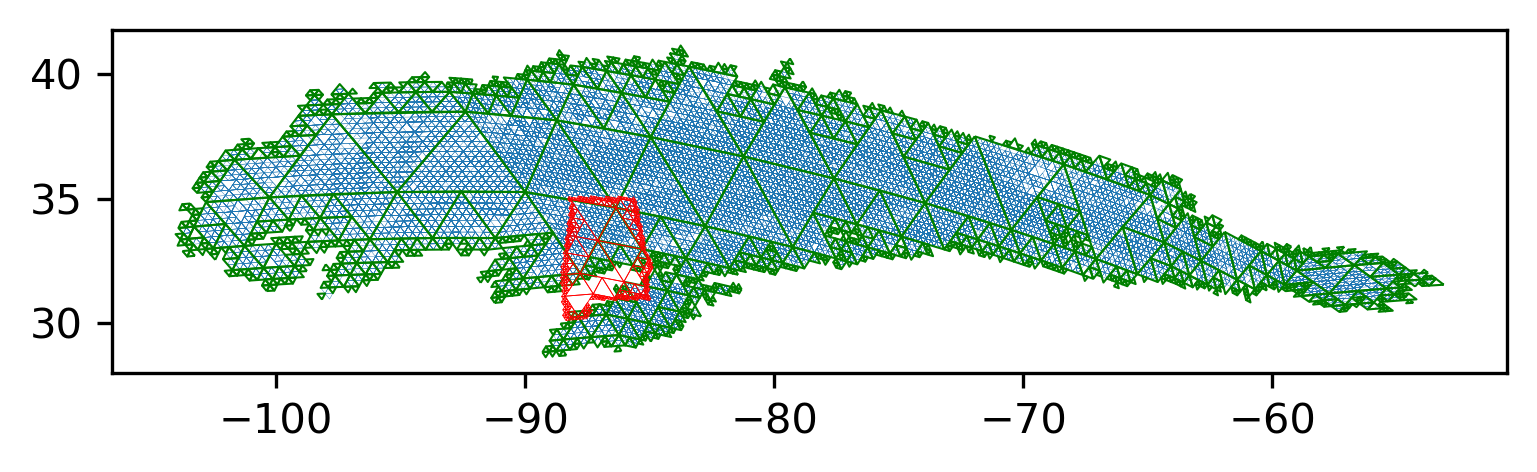

In [13]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot()

dissolved_sids = event_17.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])
trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='g')

event_17.plot(ax=ax, zorder=1, linewidth=0.1)
alabama.plot(ax=ax, zorder=3, color='r', linewidth=0.2)

# Calculating precip 

## Precip for the whole event

In [14]:
tot_precip = event_17.tot_precip.sum()
print(f'Total Precip: {tot_precip:,.2f} cubic meters')

Total Precip: 61,980,755,210.15 cubic meters


## Getting timeframes of the event that intersected Alabama

In [15]:
intersects = event_17.stare_intersects(alabama_sids)
over_alabama = event_17.reset_index()[intersects]

## Getting the cells/sids/trixels that intersect Alabama

In [16]:
over_alabama['in'] =  over_alabama['sids'].apply(lambda row: pystare.intersects(alabama_sids, row))

## Calculating Total Precip over alabama

In [17]:
def calc_tot_precip(row):
    return (row['cell_areas']*row['precips']/1000/2*row['in']).sum()
    
over_alabama['precip_in_alabama'] = over_alabama.apply(lambda row: calc_tot_precip(row), axis=1)

In [18]:
alabama_precip = over_alabama['precip_in_alabama'].sum()
alabama_precip_share = alabama_precip/tot_precip * 100
print(f'Share of event 17 in Alabama is {alabama_precip_share:2.2f} %')

Share of event 17 in Alabama is 4.38 %


# Total Runtime

In [19]:
print(datetime.datetime.now()-start)

0:01:28.621425


In [20]:
event_17.timestamp.max()-event_17.timestamp.min()

Timedelta('2 days 12:30:00')

In [21]:
over_alabama.timestamp.max()-over_alabama.timestamp.min()

Timedelta('1 days 18:30:00')

In [22]:
event_17.timestamp.min(),event_17.timestamp.max()

(Timestamp('2021-01-24 20:30:00'), Timestamp('2021-01-27 09:00:00'))

In [23]:
dissolved_event.sids.values[0]

array([2460091296451133447, 2460135276916244489, 2460144073009266697, ...,
       3440151980985548807, 3440189364380893193, 3440198160473915401])

<AxesSubplot:>

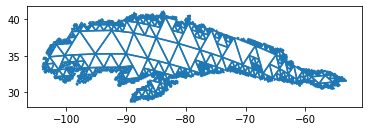

In [24]:
dissolved_event.plot()

In [25]:
type(dissolved_event)

starepandas.staredataframe.STAREDataFrame

In [26]:
dissolved_event_sids=starepandas.STAREDataFrame(sids=numpy.unique(pystare.spatial_clear_to_resolution(pystare.spatial_coerce_resolution(dissolved_event.sids.values[0],4)))).hex()

In [27]:
dissolved_event_sids

['0x2220000000000004',
 '0x2230000000000004',
 '0x2238000000000004',
 '0x2a40000000000004',
 '0x2a48000000000004',
 '0x2a50000000000004',
 '0x2a58000000000004',
 '0x2aa0000000000004',
 '0x2b40000000000004',
 '0x2b50000000000004',
 '0x2b58000000000004',
 '0x2b80000000000004',
 '0x2b88000000000004',
 '0x2b90000000000004',
 '0x2b98000000000004',
 '0x2ba0000000000004',
 '0x2ba8000000000004',
 '0x2bb0000000000004',
 '0x2bb8000000000004',
 '0x2be8000000000004',
 '0x2bf0000000000004',
 '0x2bf8000000000004',
 '0x2e40000000000004',
 '0x2e50000000000004',
 '0x2e58000000000004',
 '0x2f20000000000004',
 '0x2fa0000000000004',
 '0x2fa8000000000004',
 '0x2fb8000000000004']

In [28]:
# pattern='S1.1C.F16.*2021012[4567].*'

In [29]:
pattern='S1.1C.F16.*20210124.*'

In [30]:
pattern='S1\.1C..*\.2021012[4567].*'

In [32]:
# del s1

In [33]:
# sids_=['0x2220000000000004']
sids_=dissolved_event_sids

In [34]:
s1 = starepandas.read_pods(pod_root='/tablespace/xcal/starepods/', sids=sids_, pattern=pattern, add_podname=True)

In [35]:
s1

lat         lon                stare                  timestamp  \
184456  31.930241  -59.143829  2460095111035201193 2021-01-24 08:40:06.000274   
184457  31.896496  -58.868835  2460097828038397385 2021-01-24 08:40:06.000274   
184546  31.820406  -59.175995  2460122402292598057 2021-01-24 08:40:08.000171   
184547  31.786724  -58.901337  2460125550909666953 2021-01-24 08:40:08.000171   
184548  31.758947  -58.625885  2460112517229812265 2021-01-24 08:40:08.000171   
...           ...         ...                  ...                        ...   
76080   34.641228 -100.019348  3439630464077190729 2021-01-27 19:40:53.000351   
76174   34.740479 -100.410370  3439628003428100649 2021-01-27 19:40:56.000018   
76175   34.769073 -100.237183  3439632523823481065 2021-01-27 19:40:56.000018   
76176   34.796680 -100.065567  3439629174077063241 2021-01-27 19:40:56.000018   
76271   34.924061 -100.286407  3439626253142914505 2021-01-27 19:40:58.000684   

               Tc1         Tc2         Tc3  \
184456  197.119995  135.410004  216.690002   
184457  198.410004  138.910004  219.039993   
184546  197.070007  135.729996  217.649994   
184547  198.460007  138.520004  219.320007   
184548  202.029999  143.630005  222.699997   
...            ...         ...         ...   
76080   265.750000         NaN         NaN   
76174   265.040009         NaN         NaN   
76175   264.750000         NaN         NaN   
76176   264.940002         NaN         NaN   
76271   265.089996         NaN         NaN   

                                                      pod  
184456  /tablespace/xcal/starepods//0x2220000000000004...  
184457  /tablespace/xcal/starepods//0x2220000000000004...  
184546  /tablespace/xcal/starepods//0x2220000000000004...  
184547  /tablespace/xcal/starepods//0x2220000000000004...  
184548  /tablespace/xcal/starepods//0x2220000000000004...  
...                                                   ...  
76080   /tablespace/xcal/starepods//0x2fb8000000000004...  
76174   /tablespace/xcal/starepods//0x2fb8000000000004...  
76175   /tablespace/xcal/starepods//0x2fb8000000000004...  
76176   /tablespace/xcal/starepods//0x2fb8000000000004...  
76271   /tablespace/xcal/starepods//0x2fb8000000000004...  

[856626 rows x 8 columns]

In [36]:
# for i in range(76271,76271+100):
#     print(s1['pod'].iloc[i])

In [37]:
s1[s1.pod.str.contains('ATMS')]

lat         lon                stare                  timestamp  \
145335  31.942360  -59.011578  2460100057562796744 2021-01-24 05:06:08.000018   
145430  31.754038  -58.649693  2460116743684150280 2021-01-24 05:06:10.000684   
145431  31.786253  -59.040134  2460123464780149832 2021-01-24 05:06:10.000684   
145525  31.566347  -58.311348  2460172320385932424 2021-01-24 05:06:13.000351   
145526  31.598013  -58.680866  2460209015955417544 2021-01-24 05:06:13.000351   
...           ...         ...                  ...                        ...   
76080   34.641228 -100.019348  3439630464077190729 2021-01-27 19:40:53.000351   
76174   34.740479 -100.410370  3439628003428100649 2021-01-27 19:40:56.000018   
76175   34.769073 -100.237183  3439632523823481065 2021-01-27 19:40:56.000018   
76176   34.796680 -100.065567  3439629174077063241 2021-01-27 19:40:56.000018   
76271   34.924061 -100.286407  3439626253142914505 2021-01-27 19:40:58.000684   

               Tc1  Tc2  Tc3  \
145335  193.869995  NaN  NaN   
145430  192.610001  NaN  NaN   
145431  192.970001  NaN  NaN   
145525  192.130005  NaN  NaN   
145526  192.210007  NaN  NaN   
...            ...  ...  ...   
76080   265.750000  NaN  NaN   
76174   265.040009  NaN  NaN   
76175   264.750000  NaN  NaN   
76176   264.940002  NaN  NaN   
76271   265.089996  NaN  NaN   

                                                      pod  
145335  /tablespace/xcal/starepods//0x2220000000000004...  
145430  /tablespace/xcal/starepods//0x2220000000000004...  
145431  /tablespace/xcal/starepods//0x2220000000000004...  
145525  /tablespace/xcal/starepods//0x2220000000000004...  
145526  /tablespace/xcal/starepods//0x2220000000000004...  
...                                                   ...  
76080   /tablespace/xcal/starepods//0x2fb8000000000004...  
76174   /tablespace/xcal/starepods//0x2fb8000000000004...  
76175   /tablespace/xcal/starepods//0x2fb8000000000004...  
76176   /tablespace/xcal/starepods//0x2fb8000000000004...  
76271   /tablespace/xcal/starepods//0x2fb8000000000004...  

[285210 rows x 8 columns]

In [38]:
s1[s1.pod.str.contains('F17')]

lat         lon                stare                  timestamp  \
188934  28.792387  -54.462463  2459538384027259337 2021-01-24 10:13:37.000257   
189019  29.500687  -55.420197  2459743472107366697 2021-01-24 10:13:39.000157   
189020  29.328491  -55.242737  2459739762916333961 2021-01-24 10:13:39.000157   
189021  29.160393  -55.060547  2459570961627749417 2021-01-24 10:13:39.000157   
189022  28.996500  -54.873718  2459585041345288937 2021-01-24 10:13:39.000157   
...           ...         ...                  ...                        ...   
99088   33.890835 -100.752838  3439678733466805417 2021-01-28 00:18:31.000997   
99089   33.659641 -100.776276  3439680237282760201 2021-01-28 00:18:31.000997   
99178   33.997559 -100.798065  3439677230695734185 2021-01-28 00:18:33.000896   
99179   33.766354 -100.821350  3439684921714547753 2021-01-28 00:18:33.000896   
99269   33.872986 -100.866516  3439677641133173833 2021-01-28 00:18:35.000794   

               Tc1         Tc2         Tc3  \
188934  201.619995  140.380005  232.429993   
189019  202.399994  142.600006  230.130005   
189020  203.779999  143.429993  233.130005   
189021  203.369995  142.899994  232.779999   
189022  201.300003  140.330002  232.270004   
...            ...         ...         ...   
99088   265.019989  252.490005  265.070007   
99089   265.630005  252.410004  266.000000   
99178   265.390015  252.399994  265.010010   
99179   265.339996  251.309998  266.019989   
99269   264.859985  251.380005  264.519989   

                                                      pod  
188934  /tablespace/xcal/starepods//0x2220000000000004...  
189019  /tablespace/xcal/starepods//0x2220000000000004...  
189020  /tablespace/xcal/starepods//0x2220000000000004...  
189021  /tablespace/xcal/starepods//0x2220000000000004...  
189022  /tablespace/xcal/starepods//0x2220000000000004...  
...                                                   ...  
99088   /tablespace/xcal/starepods//0x2fb8000000000004...  
99089   /tablespace/xcal/starepods//0x2fb8000000000004...  
99178   /tablespace/xcal/starepods//0x2fb8000000000004...  
99179   /tablespace/xcal/starepods//0x2fb8000000000004...  
99269   /tablespace/xcal/starepods//0x2fb8000000000004...  

[192175 rows x 8 columns]

In [39]:
s1.pod.values.size

856626

In [40]:
s1.pod.values

array(['/tablespace/xcal/starepods//0x2220000000000004/S1.1C.F16.SSMIS.XCAL2016-V.20210124-S073514-E091708.089109.V05A.HDF5.pickle',
       '/tablespace/xcal/starepods//0x2220000000000004/S1.1C.F16.SSMIS.XCAL2016-V.20210124-S073514-E091708.089109.V05A.HDF5.pickle',
       '/tablespace/xcal/starepods//0x2220000000000004/S1.1C.F16.SSMIS.XCAL2016-V.20210124-S073514-E091708.089109.V05A.HDF5.pickle',
       ...,
       '/tablespace/xcal/starepods//0x2fb8000000000004/S1.1C.NPP.ATMS.XCAL2019-V.20210127-S190539-E204708.047945.V05C.HDF5.pickle',
       '/tablespace/xcal/starepods//0x2fb8000000000004/S1.1C.NPP.ATMS.XCAL2019-V.20210127-S190539-E204708.047945.V05C.HDF5.pickle',
       '/tablespace/xcal/starepods//0x2fb8000000000004/S1.1C.NPP.ATMS.XCAL2019-V.20210127-S190539-E204708.047945.V05C.HDF5.pickle'],
      dtype=object)

In [41]:
s1.set_sids('stare',inplace=True)
s1.set_trixels(s1.make_trixels(n_workers=50, wrap_lon=False),inplace=True)
# s1.split_antimeridian(inplace=True)

In [42]:
s1['level']=2**(10-pystare.spatial_resolution(s1['stare']))

In [43]:
s1.set_geometry(geopandas.points_from_xy(s1.lon, s1.lat, crs=4326), inplace=True)
# s1_.set_trixels(s1_.make_trixels(n_workers=600), inplace=True)

In [44]:
s1.reset_index(inplace=True)

In [45]:
# mask = s1.stare_intersects(dissolved_event['sids'].iloc[0])
mask = s1.stare_intersects(dissolved_event.sids.values[0])

In [46]:
dissolved_event

sids  \
0  [2460091296451133447, 2460135276916244489, 246...   

                                             trixels  
0  MULTIPOLYGON (((-59.02390 32.10799, -59.51088 ...

In [47]:
mask

0         True
1         True
2         True
3         True
4         True
          ... 
856621    True
856622    True
856623    True
856624    True
856625    True
Length: 856626, dtype: bool

In [48]:
roi=dissolved_event
s1_ = s1.reset_index()[mask]
mnmx(pystare.spatial_resolution(s1_.stare))

(7, 9)

In [49]:
# bounds = roi.bounds.values.flatten(); bounds

In [50]:
# bbox = [bounds[0],bounds[2],bounds[1],bounds[3]]; bbox

F16  size:  966355
F17  size:  1003340
F18  size:  962312
NOAA20  size:  764738
NPP  size:  756925


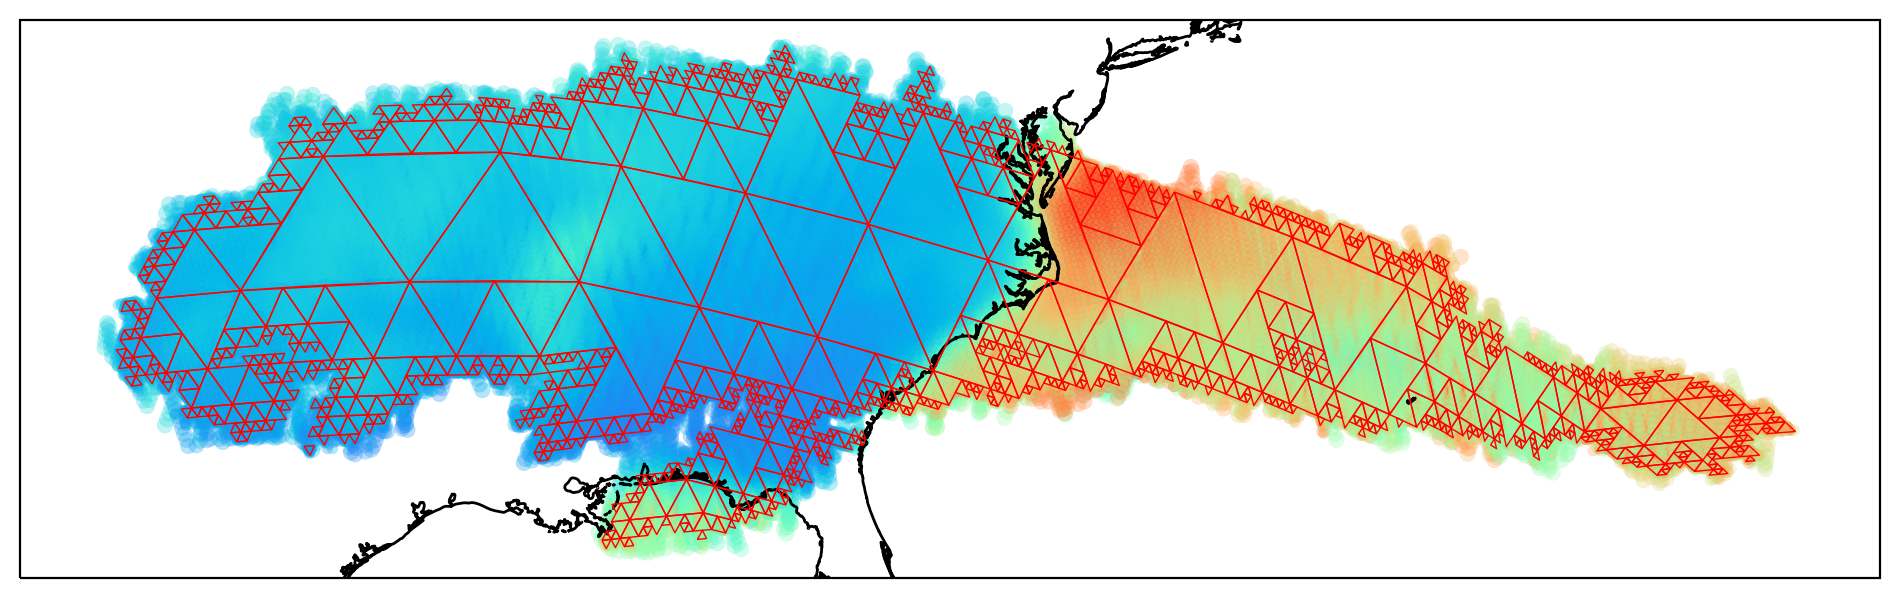

In [57]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
# ax.set_extent([-82.5, -72.5, 35, 40])
# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

# roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16':'r'
    ,'F17':'g'
    ,'F18':'b'
    ,'NOAA20':'y'
    ,'NPP':'c'
}

vmin = min(s1_.Tc1)
vmax = max(s1_.Tc1)

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    l  = 1
    print(k,' size: ',s_.size)
    if s_.size > 0:
        #++ 
        s_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=4*s_['level'], alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)

        # b = [4282096412885254152]
        # b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='r')
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

In [54]:
vmin = min(s1_.Tc1)
vmax = max(s1_.Tc1)
vmin,vmax

(142.22999572753906, 310.19000244140625)

F16  size:  966355
F17  size:  1003340
F18  size:  962312
NOAA20  size:  764738
NPP  size:  756925


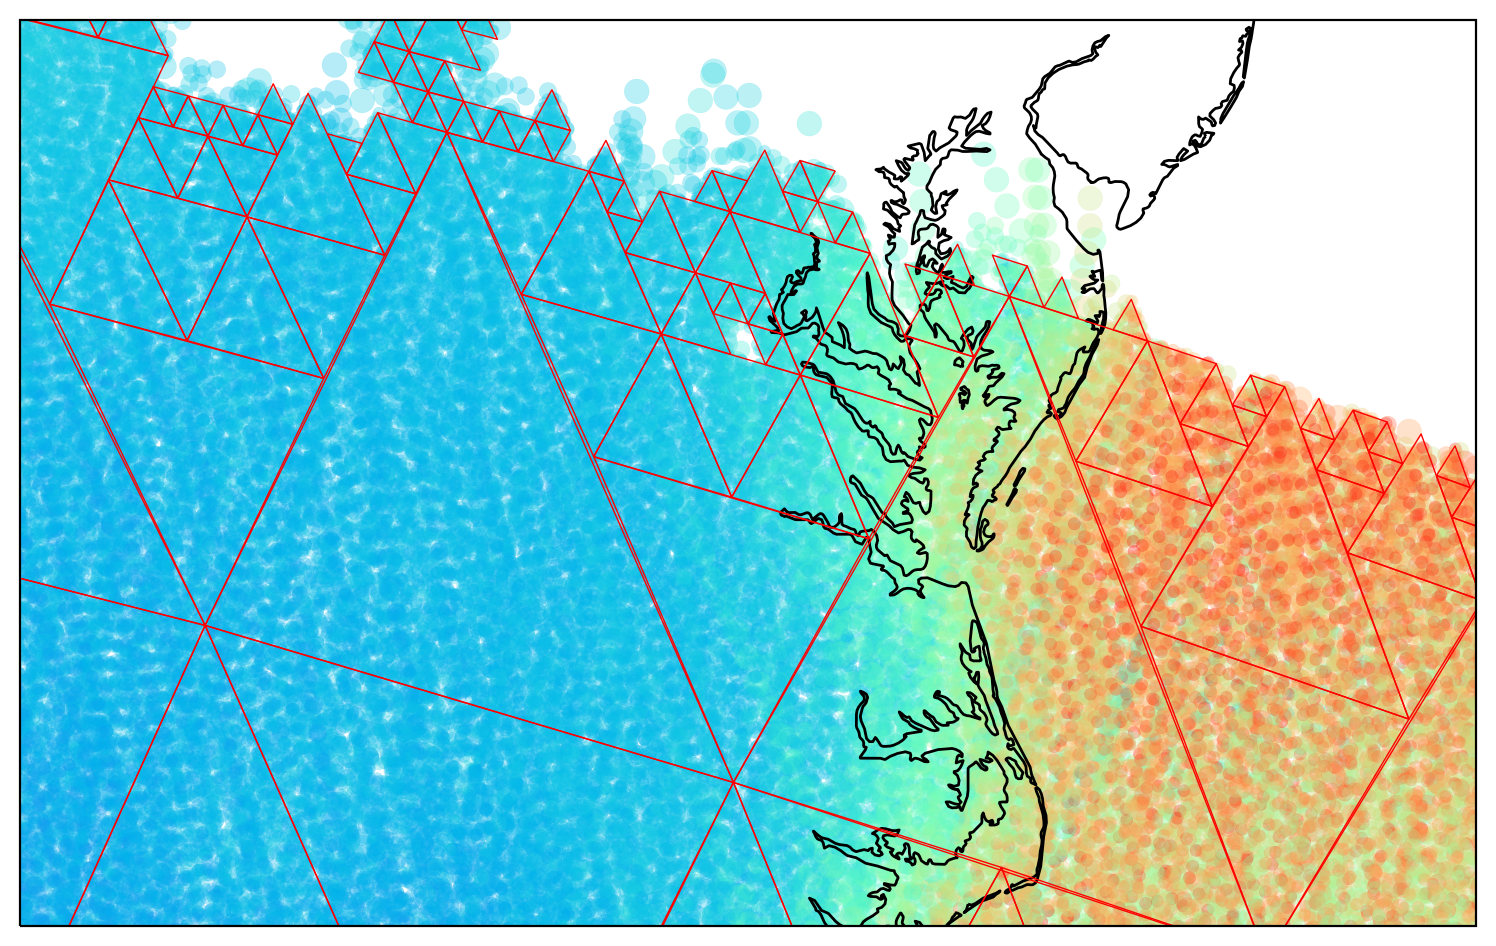

In [56]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
ax.set_extent([-82.5, -72.5, 35, 40])
# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

# roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16':'r'
    ,'F17':'g'
    ,'F18':'b'
    ,'NOAA20':'y'
    ,'NPP':'c'
}

vmin = min(s1_.Tc1)
vmax = max(s1_.Tc1)

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    l  = 1
    print(k,' size: ',s_.size)
    if s_.size > 0:
        #++ 
        s_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s_['level'], alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)

        # b = [4282096412885254152]
        # b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='r')
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

F16  size:  966355
F17  size:  1003340
F18  size:  962312
NOAA20  size:  764738
NPP  size:  756925


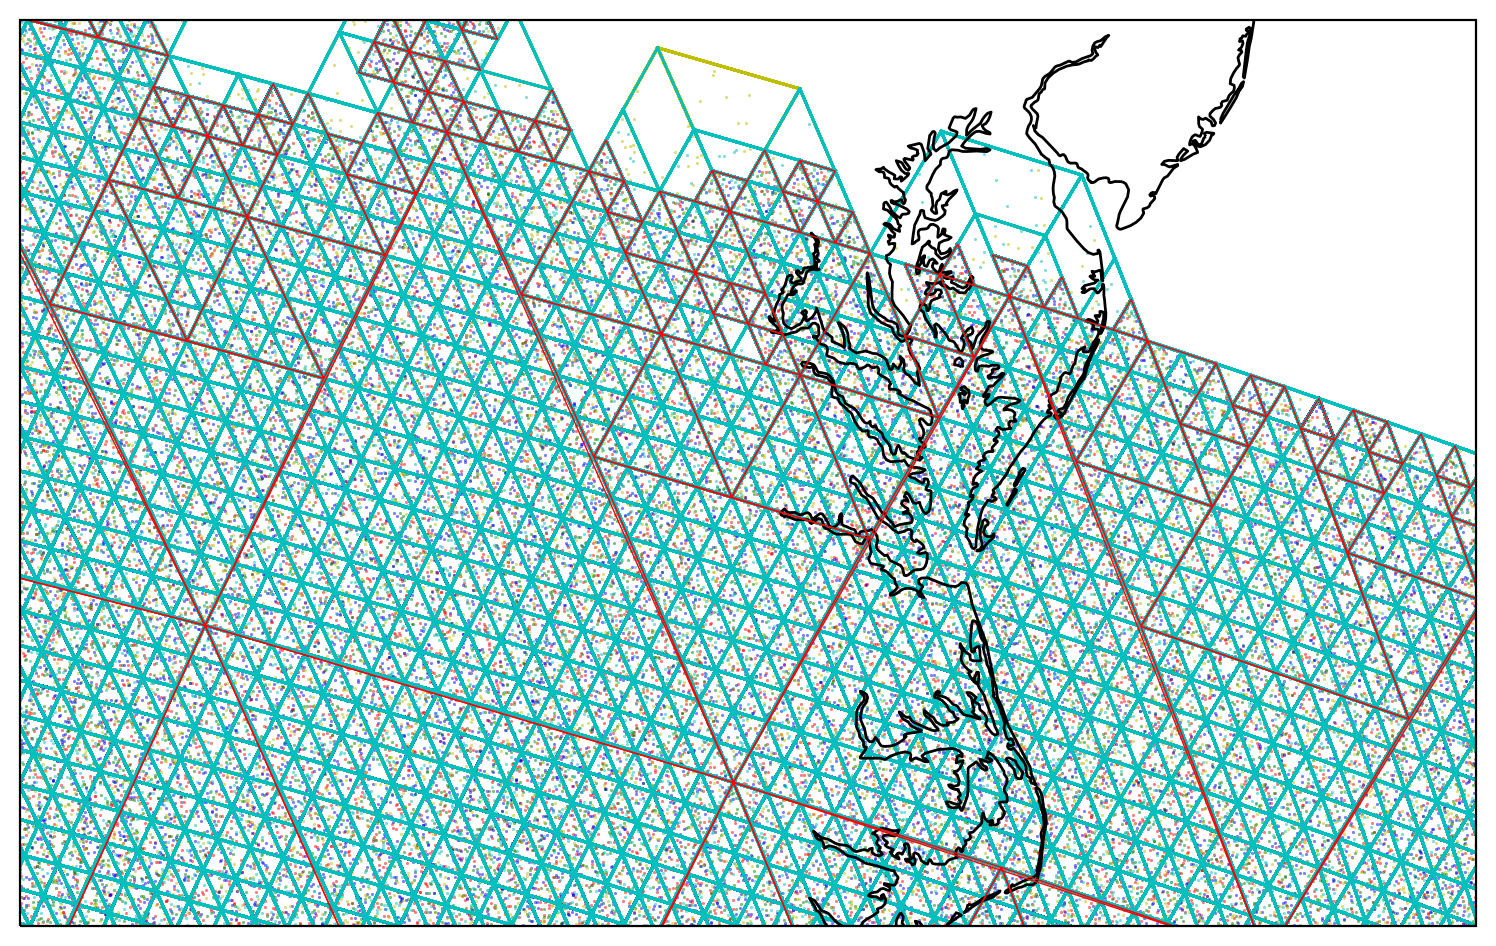

In [52]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
ax.set_extent([-82.5, -72.5, 35, 40])
# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

# roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16':'r'
    ,'F17':'g'
    ,'F18':'b'
    ,'NOAA20':'y'
    ,'NPP':'c'
}

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    l  = 1
    print(k,' size: ',s_.size)
    if s_.size > 0:
        #++ 
        # s_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=2*s_['level'], alpha=0.4, cmap='rainbow_r')
        s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)

        # b = [4282096412885254152]
        b=s_.stare
        usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='r')
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

In [ ]:
colors

In [ ]:
import glob
import re

In [ ]:
hex(2460125550909666953)

In [ ]:
pod_path = '/tablespace/xcal/starepods/0x2228000000000004/'
pickles = sorted(glob.glob(os.path.expanduser(pod_path + '/*')))

In [ ]:
pickles

In [ ]:
hex(2460091296451133447)

In [ ]:
'0x2224000000000007'

In [ ]:
pattern='S1.*2021012[4567].*'

In [ ]:
pattern='S1.1C.*20210124.*'

In [ ]:
pattern='S1\.1C.F16.*20210124.*'

In [ ]:
pattern='S1'

In [ ]:
pattern='S1.1C..*.20210124.*'

In [ ]:
pattern='S1.1C..*.2021012[4567].*'
pattern='S1\.1C..*\.2021012[4567].*'

In [ ]:
search = '.*{pattern}.*'.format(pattern=pattern); search

In [ ]:
pods = list(filter(re.compile(search).match, pickles))

In [ ]:
pods

In [ ]:
len(pods)